In [1]:
import mmcv
import torch
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
                         wrap_fp16_model)
from mmcv.utils import DictAction
from mmcv import Config
from mmseg.apis import multi_gpu_test, single_gpu_test
from mmseg.datasets import build_dataloader, build_dataset
from mmseg.models import build_segmentor
from glob import glob

import matplotlib.pyplot as plt
import albumentations as A
from mmcv import Config
import os
import numpy as np
from tqdm import tqdm
import pandas as pd

In [2]:
MODEL = 'unet_swinB.py' # model config 경로
PATH = '/opt/ml/segmentation/moon/mmsegmentation/work_dirs/unet_swinB' # 모델 저장된 폴더
BEST_CHECKPOINT = glob(os.path.join(PATH,'best_*'))
#BEST_CHECKPOINT = ['/opt/ml/segmentation/moon/mmsegmentation/work_dirs/dyhead_swinB/epoch_50.pth']
assert len(BEST_CHECKPOINT)==1
BEST_CHECKPOINT = BEST_CHECKPOINT[0]

cfg =Config.fromfile(os.path.join(PATH,MODEL))
cfg.data.test.test_mode = True

In [3]:
cfg.data.test['img_dir'] = 'images/train'
cfg.data.test['ann_dir'] = 'annotations/train'
cfg.data.test['pipeline'][1]['flip']=True
# size_min = 512
# size_max = 1024
# multi_scale_list = [(x,x) for x in range(size_min, size_max+1, 128)]
# cfg.data.test.pipeline[1]['img_scale'] = multi_scale_list # Resize

In [4]:
test_dataset = build_dataset(cfg.data.test)
test_loader = build_dataloader(
        test_dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

2021-10-26 22:14:48,204 - mmseg - INFO - Loaded 2617 images


In [5]:
# build model
cfg.model.pretrained = None
cfg.model.train_cfg = None

checkpoint_path = BEST_CHECKPOINT

model = build_segmentor(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu')

Use load_from_local loader


In [6]:
model.CLASSES = checkpoint['meta']['CLASSES']
model.PALETTE = checkpoint['meta']['PALETTE']
model = MMDataParallel(model.cuda(), device_ids=[0])

In [7]:
# encoder_decoder.py에서 출력값 변경
output = single_gpu_test(model, test_loader) # 819x11x512x512

[                                ] 2/2617, 3.5 task/s, elapsed: 1s, ETA:   753s

/opt/conda/envs/mmseg/lib/python3.7/site-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2617/2617, 7.5 task/s, elapsed: 350s, ETA:     0s

---

# Data Cleaning

In [9]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [13]:
score_list=[]
output = np.array(output)
output = torch.from_numpy(output)

scores,a = output.max(axis=1)
general_trash_scores = scores[(a==1)]

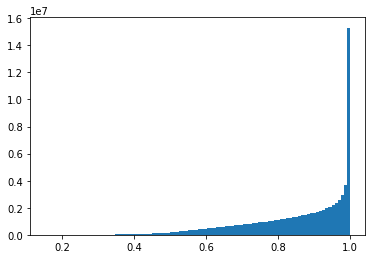

In [82]:
plt.hist(general_trash_scores.flatten(),bins=100,cumulative=True)
plt.show()

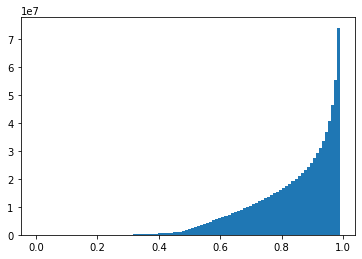

In [28]:
plt.hist(scores.flatten(),bins=100,cumulative=True)
plt.show()

In [103]:
#print((scores<0.5).sum()/len(scores) * 100)
print((general_trash_scores<0.5).sum()/len(general_trash_scores) * 100)

1.1000072332787276


In [109]:
threshold = 0.5
clean_path = '/opt/ml/segmentation/moon/dataset/annotations/clean_train/'
origin_path = '/opt/ml/segmentation/moon/dataset/annotations/train/'
img_infos = test_dataset.img_infos
file_names = [img_info['ann']['seg_map'] for img_info in img_infos]
for file_name,seg_logit in tqdm(zip(file_names,output)):
    origin_ann_path = os.path.join(origin_path,file_name)
    clean_ann_path = os.path.join(clean_path,file_name)

    origin_ann = np.array(Image.open(origin_ann_path)) # 512 x 512
    clean_mask = np.ones_like(origin_ann)
    ann_score = seg_logit.max(axis=0)[0] # 512 x 512
    clean_mask[ann_score<threshold]=0

    clean_ann = origin_ann * clean_mask

    cv2.imwrite(clean_ann_path,clean_ann)

2617it [00:24, 108.29it/s]
